In [14]:
from skimage import io
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.decomposition import PCA
from skimage.transform import SimilarityTransform
from skimage.transform import warp
import os
import pathlib

Exercise 1

In [15]:
# Given functions from data\readme.md
def read_landmark_file(file_name):
    f = open(file_name, 'r')
    lm_s = f.readline().strip().split(' ')
    n_lms = int(lm_s[0])
    if n_lms < 3:
        print(f"Not enough landmarks found")
        return None

    new_lms = 3
    # 3 landmarks each with (x,y)
    lm = np.zeros((new_lms, 2))
    for i in range(new_lms):
        lm[i, 0] = lm_s[1 + i * 2]
        lm[i, 1] = lm_s[2 + i * 2]
    return lm

def align_and_crop_one_cat_to_destination_cat(img_src, lm_src, img_dst, lm_dst):
    """
    Landmark based alignment of one cat image to a destination
    :param img_src: Image of source cat
    :param lm_src: Landmarks for source cat
    :param lm_dst: Landmarks for destination cat
    :return: Warped and cropped source image. None if something did not work
    """
    tform = SimilarityTransform()
    tform.estimate(lm_src, lm_dst)
    warped = warp(img_src, tform.inverse, output_shape=img_dst.shape)

    # Center of crop region
    cy = 185
    cx = 210
    # half the size of the crop box
    sz = 180
    warp_crop = warped[cy - sz:cy + sz, cx - sz:cx + sz]
    shape = warp_crop.shape
    if shape[0] == sz * 2 and shape[1] == sz * 2:
        return img_as_ubyte(warp_crop)
    else:
        print(f"Could not crop image. It has shape {shape}. Probably to close to border of image")
        return None

def preprocess_all_cats(in_dir, out_dir):

    """Create aligned and cropped version of image
    :param in_dir: Where are the original photos and landmark files
    :param out_dir: Where should the preprocessed files be placed
    """
    dst = "data/ModelCat"
    dst_lm = read_landmark_file(f"{dst}.jpg.cat")
    dst_img = io.imread(f"{dst}.jpg")

    all_images = glob.glob(in_dir + "*.jpg")
    for img_idx in all_images:
        name_no_ext = os.path.splitext(img_idx)[0]
        base_name = os.path.basename(name_no_ext)
        out_name = f"{out_dir}/{base_name}_preprocessed.jpg"

        src_lm = read_landmark_file(f"{name_no_ext}.jpg.cat")
        src_img = io.imread(f"{name_no_ext}.jpg")

        proc_img = align_and_crop_one_cat_to_destination_cat(src_img, src_lm, dst_img, dst_lm)
        if proc_img is not None:
            io.imsave(out_name, proc_img)

def preprocess_one_cat():
    src = "data/MissingCat"
    dst = "data/ModelCat"
    out = "data/MissingCatProcessed.jpg"

    src_lm = read_landmark_file(f"{src}.jpg.cat")
    dst_lm = read_landmark_file(f"{dst}.jpg.cat")

    src_img = io.imread(f"{src}.jpg")
    dst_img = io.imread(f"{dst}.jpg")

    src_proc = align_and_crop_one_cat_to_destination_cat(src_img, src_lm, dst_img, dst_lm)
    if src_proc is None:
        return

    io.imsave(out, src_proc)

    fig, ax = plt.subplots(ncols=3, figsize=(16, 6))
    ax[0].imshow(src_img)
    ax[0].plot(src_lm[:, 0], src_lm[:, 1], '.r', markersize=12)
    ax[1].imshow(dst_img)
    ax[1].plot(dst_lm[:, 0], dst_lm[:, 1], '.r', markersize=12)
    ax[2].imshow(src_proc)
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()

def create_u_byte_image_from_vector(im_vec, height, width, channels):
    min_val = im_vec.min()
    max_val = im_vec.max()

    # Transform to [0, 1]
    im_vec = np.subtract(im_vec, min_val)
    im_vec = np.divide(im_vec, max_val - min_val)
    im_vec = im_vec.reshape(height, width, channels)
    im_out = img_as_ubyte(im_vec)
    return im_out

In [16]:
in_dir = "training_data_100/"
out_dir = "preprocessed_cats/"

preprocess_all_cats(in_dir, out_dir)

Exercise 2

In [17]:
# 1. Find all preprocessed images
image_files = glob.glob("preprocessed_cats/*.jpg")
n_samples = len(image_files)
print(f"Found {n_samples} images.")

# 2. Read one image to get shape (height, width, channels)
sample_img = io.imread(image_files[0])
height, width, channels = sample_img.shape
n_features = height * width * channels
print(f"Image shape: {height}x{width}x{channels} -> {n_features} features")

# 3. Allocate empty data matrix
data_matrix = np.zeros((n_samples, n_features), dtype=np.uint8)

# 4. Fill the data matrix
for idx, file in enumerate(image_files):
    img = io.imread(file)
    flat_img = img.flatten()
    data_matrix[idx, :] = flat_img

print("Data matrix shape:", data_matrix.shape)


Found 100 images.
Image shape: 360x360x3 -> 388800 features
Data matrix shape: (100, 388800)


Exercise 3 & 4

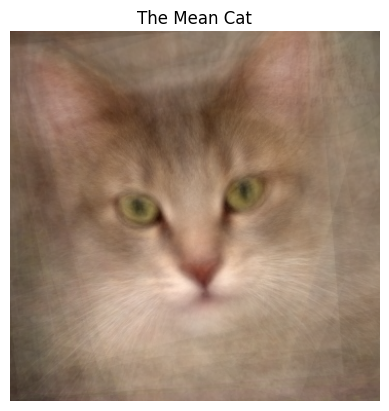

In [18]:
mean_cat_vec = np.mean(data_matrix, axis=0)

# Reshape back into image format
mean_cat_img = create_u_byte_image_from_vector(mean_cat_vec, height, width, channels)

# Show it
import matplotlib.pyplot as plt
plt.imshow(mean_cat_img)
plt.axis("off")
plt.title("The Mean Cat")
plt.show()

Exercise 5-11

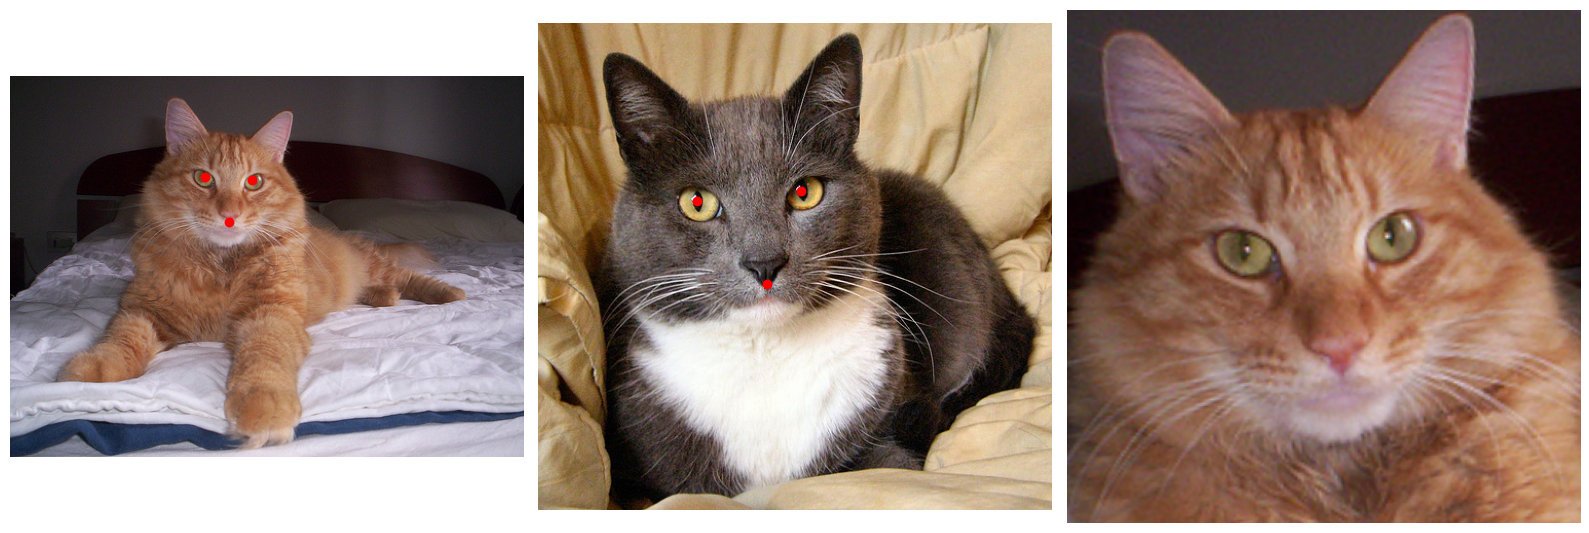

In [19]:
preprocess_one_cat()

In [20]:
file_path = "data/MissingCatProcessed.jpg"
img = io.imread(file_path)

flat_missing = img.flatten()  # shape = (height*width*channels,)

print(f"Flattened image shape: {flat_missing.shape}")

Flattened image shape: (388800,)


In [21]:
sub_data = data_matrix - flat_missing
sub_distances = np.linalg.norm(sub_data, axis=1)

In [22]:
closest_idx = np.argmin(sub_distances)  # index of the cat with smallest distance
print("Closest cat index:", closest_idx)

Closest cat index: 18


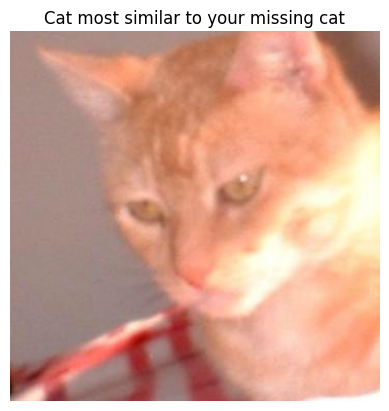

In [23]:
closest_cat_flat = data_matrix[closest_idx, :]
closest_cat_img = create_u_byte_image_from_vector(closest_cat_flat, height, width, channels)

plt.imshow(closest_cat_img)
plt.axis("off")
plt.title("Cat most similar to your missing cat")
plt.show()

Least alike cat index: 6


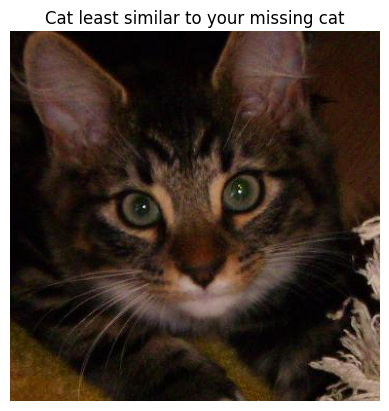

In [24]:
least_idx = np.argmax(sub_distances)
print("Least alike cat index:", least_idx)

least_cat_flat = data_matrix[least_idx, :]
least_cat_img = create_u_byte_image_from_vector(least_cat_flat, height, width, channels)

plt.imshow(least_cat_img)
plt.axis("off")
plt.title("Cat least similar to your missing cat")
plt.show()

Exercise 12


In [26]:
print("Computing PCA")
cats_pca = PCA(n_components=50)
cats_pca.fit(data_matrix)
print(cats_pca.explained_variance_ratio_)

Computing PCA
[0.26390508 0.10155236 0.09474519 0.05880997 0.03997739 0.03615279
 0.03083061 0.02570709 0.02073217 0.01835022 0.01734126 0.01600407
 0.01315352 0.01175553 0.01081381 0.00978882 0.0089039  0.00831324
 0.00782191 0.00739785 0.00706909 0.00692764 0.00660629 0.00639838
 0.00597302 0.00552115 0.00525842 0.00496832 0.00481926 0.00469737
 0.00450016 0.00431977 0.00424621 0.00404534 0.00394022 0.0038575
 0.00368677 0.00354423 0.00340988 0.00333105 0.00324712 0.00308362
 0.00303317 0.00294618 0.00282875 0.00279512 0.00277158 0.00265267
 0.00258394 0.00244487]


Exercise 13


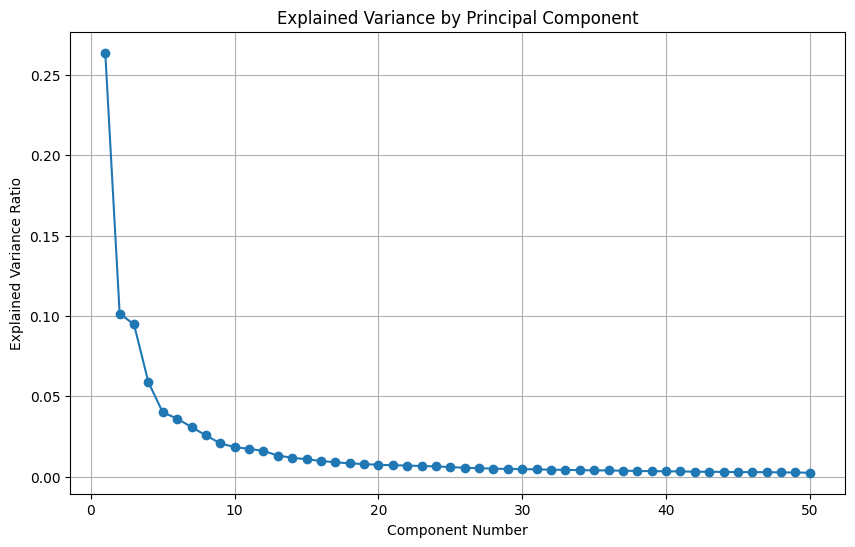

In [27]:

plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), cats_pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance by Principal Component')
plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()


Exercise 14

In [28]:
first_component_variance = cats_pca.explained_variance_ratio_[0]
print(f"Variance explained by the first component: {first_component_variance:.4f}")

Variance explained by the first component: 0.2639


Exercise 15

In [29]:
components = cats_pca.transform(data_matrix)

Exercise 16

In [30]:
# Transform the data to PCA space
cats_pca_data = cats_pca.transform(data_matrix)

# Extract the first and second PCA coordinates
pc_1 = cats_pca_data[:, 0]  # First component
pc_2 = cats_pca_data[:, 1]  # Second component

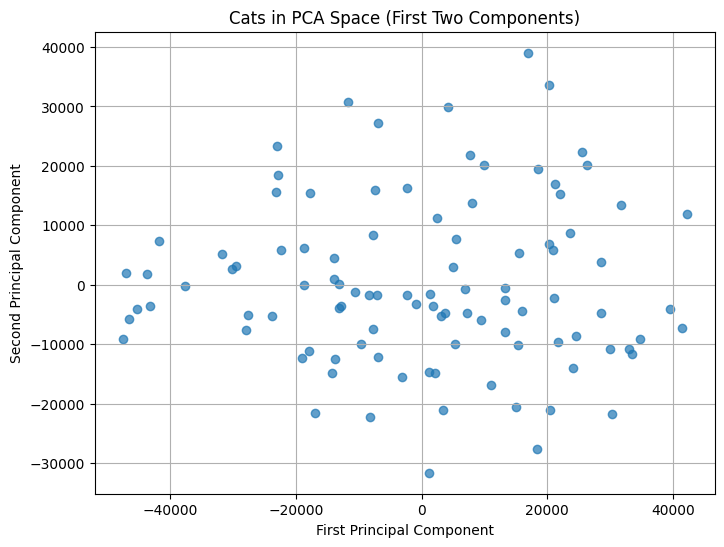

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(pc_1, pc_2, alpha=0.7)
plt.title('Cats in PCA Space (First Two Components)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True)
plt.show()

Exercise 17

65 40
18 70


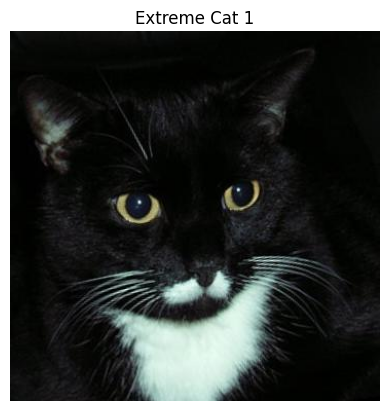

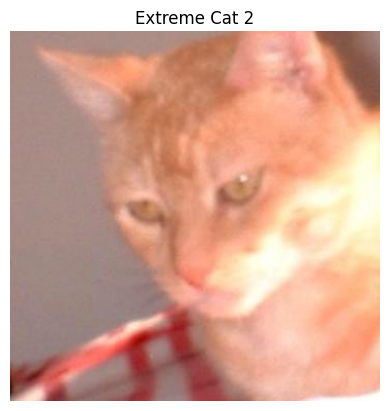

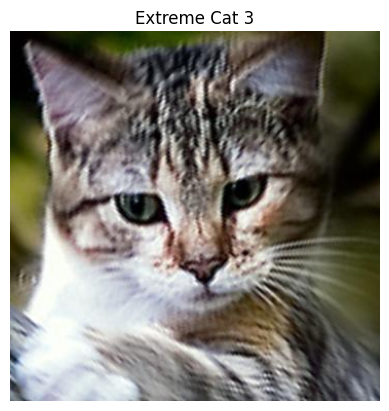

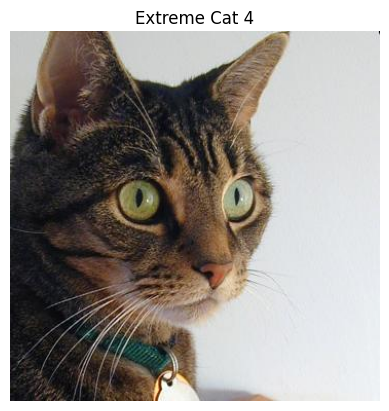

In [34]:
print(np.argmin(cats_pca_data[:, 0]), np.argmin(cats_pca_data[:, 1]))
print(np.argmax(cats_pca_data[:, 0]), np.argmax(cats_pca_data[:, 1]))

min_pc1_idx = np.argmin(cats_pca_data[:, 0])
max_pc1_idx = np.argmax(cats_pca_data[:, 0])
min_pc2_idx = np.argmin(cats_pca_data[:, 1])
max_pc2_idx = np.argmax(cats_pca_data[:, 1])

# Visualize the extreme cats
extreme_cats = [
    data_matrix[min_pc1_idx],
    data_matrix[max_pc1_idx],
    data_matrix[min_pc2_idx],
    data_matrix[max_pc2_idx]
]

for i, cat_vector in enumerate(extreme_cats):
    img = create_u_byte_image_from_vector(cat_vector, 360,360,3)
    plt.figure()
    plt.imshow(img)
    plt.title(f"Extreme Cat {i+1}")
    plt.axis('off')
    plt.show()

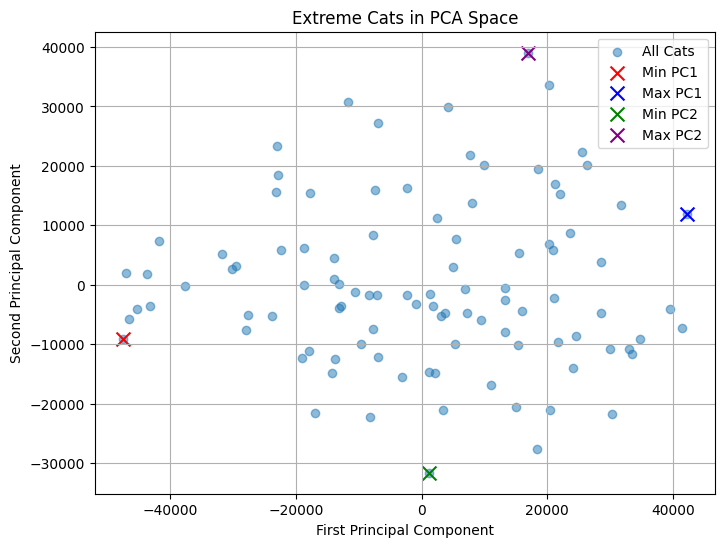

In [35]:
# Plot all cats in PCA space
plt.figure(figsize=(8, 6))
plt.scatter(cats_pca_data[:, 0], cats_pca_data[:, 1], alpha=0.5, label='All Cats')

# Highlight extreme cats
plt.scatter(cats_pca_data[min_pc1_idx, 0], cats_pca_data[min_pc1_idx, 1], color='red', marker='x', s=100, label='Min PC1')
plt.scatter(cats_pca_data[max_pc1_idx, 0], cats_pca_data[max_pc1_idx, 1], color='blue', marker='x', s=100, label='Max PC1')
plt.scatter(cats_pca_data[min_pc2_idx, 0], cats_pca_data[min_pc2_idx, 1], color='green', marker='x', s=100, label='Min PC2')
plt.scatter(cats_pca_data[max_pc2_idx, 0], cats_pca_data[max_pc2_idx, 1], color='purple', marker='x', s=100, label='Max PC2')

plt.title('Extreme Cats in PCA Space')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.grid(True)
plt.show()